**Table of contents**<a id='toc0_'></a>    
- 1. [Load data         ](#toc1_)    
- 2. [Sub-figures     ](#toc2_)    
  - 2.1. [Nankai map    ](#toc2_1_)    
  - 2.2. [Japan trench map    ](#toc2_2_)    
  - 2.3. [Small map of Japan   ](#toc2_3_)    
  - 2.4. [Time series of Nankai tremor  ](#toc2_4_)    
  - 2.5. [Japan trench time series ](#toc2_5_)    
- 3. [Full figure](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import matplotlib.colors as mcolors
from matplotlib.dates import YearLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.patheffects as fx

import rasterio
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.io.shapereader as shpreader

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

In [2]:
def distance_epi(lon1, lat1, lon2, lat2):
    """Haversine formula to compute distance between two points on Earth

    Args:
        lon1 (float): longitude of point 1 (deg)
        lat1 (float): latitude of point 1 (deg)
        lon2 (float): longitude of point 2 (deg)
        lat2 (float): latitude of point 2 (deg)

    Returns:
        distance: distance between the two points (km)
    """
    R = 6371.0 # km
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)

    a = np.sin(dlat/2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    distance = R * c

    return distance


# 1. <a id='toc1_'></a>Load data          [&#128285;](#toc0_)

In [3]:
# Catalogs
# Nankai
trm_nk = pd.read_csv('../data/nankai/processed/nank_trm_0101_0423.csv', parse_dates=['date'])
eq_nk = pd.read_csv('../data/nankai/processed/nank_eq_0101_0423.csv', parse_dates=['date'])

# Japan trench
trm_jp = pd.read_csv('../data/jptrench/processed/jpt_trm_0816_0122.csv', parse_dates=['date'])
eq_jp = pd.read_csv('../data/jptrench/processed/jpt_eq_0816_0122.csv', parse_dates=['date'])

In [4]:
# Slabs and trenches
# --> Pacific plate
# slab
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PAC_Plate/pac_regional/pac_2017_4a.xyz"
names = ['lon', 'lat', 'depth']
pac_slab = pd.read_csv(path, sep=r'\s+', names=names)
pac_slab.depth = -pac_slab.depth

# contours
dir_path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PAC_Plate/pac_regional/contour/"

files = os.listdir(dir_path)
depths = [int(file.split('_')[2]) for file in files if file.endswith('rg')]
depths = np.sort(depths)

pac_slab_contours = dict()

for d in depths:
    path = dir_path + 'pac1_cntr_' + str(d) + '_rg'
    contour = np.loadtxt(path)
    contour = contour[:, :2]

    pac_slab_contours[d] = {'lon': contour[:, 0], 'lat': contour[:, 1]}
    in_range = np.where((contour[:, 0] > 0) | (contour[:, 1] > 0))[0]
    pac_slab_contours[d]['lon'] = pac_slab_contours[d]['lon'][in_range]
    pac_slab_contours[d]['lat'] = pac_slab_contours[d]['lat'][in_range]

# trench
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/Trench/japan_trench_pos"
names = ['lon', 'lat', 'water_depth', '_', '__', '___']
pac_trench = pd.read_csv(path, sep=r'\s+', names=names)
pac_trench = pac_trench[['lon', 'lat', 'water_depth']]
pac_trench = pac_trench[pac_trench.lon > 0]
pac_trench.sort_values(by='lat', inplace=True)

# --> Philippine Sea plate
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PHS_Plate/phs_regional/phs_2015_5a_r_2017.xyz"
names = ['lon', 'lat', 'depth']
phs_slab = pd.read_csv(path, sep=r'\s+', names=names)
phs_slab.depth = -phs_slab.depth

# contours
dir_path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/PHS_Plate/phs_regional/contour/"

files = os.listdir(dir_path)
depths = [int(file.split('_')[2]) for file in files if file.endswith('rg')]
depths = np.sort(depths)

phs_slab_contours = dict()

for d in depths:
    path = dir_path + 'phs1_cntr_' + str(d) + '_rg'
    contour = np.loadtxt(path)
    contour = contour[:, :2]

    phs_slab_contours[d] = {'lon': contour[:, 0], 'lat': contour[:, 1]}
    in_range = np.where((contour[:, 0] > 0) | (contour[:, 1] > 0))[0]
    phs_slab_contours[d]['lon'] = phs_slab_contours[d]['lon'][in_range]
    phs_slab_contours[d]['lat'] = phs_slab_contours[d]['lat'][in_range]


# trench
path = workdir + "projects/data/Slabs/japan/japan_slabs_iwasaki2016/Trench/nankai_trough_pos"
names = ['lon', 'lat', 'water_depth', '_', '__', '___']
phs_trench = pd.read_csv(path, sep=r'\s+', names=names)
phs_trench = phs_trench[['lon', 'lat', 'water_depth']]
phs_trench = phs_trench[phs_trench.lon > 0]
phs_trench.sort_values(by='lon', inplace=True)

In [5]:
# Geographic boundaries
lon_min_nk = trm_nk.lon.min() - 1
lon_max_nk = trm_nk.lon.max() + 1
lat_min_nk = trm_nk.lat.min() - 1
lat_max_nk = trm_nk.lat.max() + 1

lon_min_jp = trm_jp.lon.min() - 0.9
lon_max_jp = trm_jp.lon.max() + 1.1
lat_min_jp = trm_jp.lat.min() - 1
lat_max_jp = trm_jp.lat.max() + 1

In [6]:
# Topography/bathymetry
path = workdir + "projects/data/Bathymetry/Global/gebco_2024_geotiff/gebco_2024_n90.0_s0.0_w90.0_e180.0.tif"

with rasterio.open(path) as src:
    dem_nk = src.read(1, window=src.window(left=lon_min_nk, right=lon_max_nk, top=lat_max_nk, bottom=lat_min_nk))
    dem_jp = src.read(1, window=src.window(left=lon_min_jp, right=lon_max_jp, top=lat_max_jp, bottom=lat_min_jp))

# Spatial resolution
dlon, dlat = (lat_max_nk - lat_min_nk) / dem_nk.shape[0], (lon_max_nk - lon_min_nk) / dem_nk.shape[1]
dx = dlon * 111.32e3 * np.cos(np.radians(trm_nk.lat.mean()))
dy = dlat * 111.32e3

# 2. <a id='toc2_'></a>Sub-figures      [&#128285;](#toc0_)

In [7]:
min_mag = 2.2  # minimum considered magnitude
max_dist = 50  # max distance for earthquakes "felt by tremor"

sci_adv_red = [183/255, 53/255, 47/255]

## 2.1. <a id='toc2_1_'></a>Nankai map     [&#128285;](#toc0_)

In [8]:
# Map parameters
crs_nk = ccrs.Mercator(central_longitude=trm_nk.lon.mean())

ms_trm_map = 1

c_trm_map = 'k'
c_eq_map = '.5'

figsize = np.array([4, 2.25])

In [9]:
# Make a "distance-from-tremor" field, to plot the 50 km contour
dist_lon_nk = np.arange(lon_min_nk-.1, lon_max_nk+.1, .05)
dist_lat_nk = np.arange(lat_min_nk-.1, lat_max_nk+.1, .05)

dist_lon_nk, dist_lat_nk = np.meshgrid(dist_lon_nk, dist_lat_nk)
shape = dist_lon_nk.shape

dist_lon_nk = dist_lon_nk.reshape(-1)
dist_lat_nk = dist_lat_nk.reshape(-1)

dist_field_nk = distance_epi(dist_lon_nk[np.newaxis, :], dist_lat_nk[np.newaxis, :], trm_nk.lon.values[::2, np.newaxis], trm_nk.lat.values[::2, np.newaxis])
dist_field_nk = np.min(dist_field_nk, axis=0)

dist_lon_nk = dist_lon_nk.reshape(*shape)
dist_lat_nk = dist_lat_nk.reshape(*shape)
dist_field_nk = dist_field_nk.reshape(*shape)

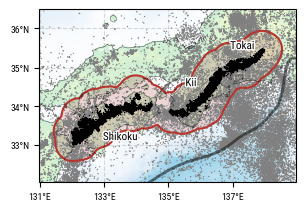

In [10]:
# Map
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': crs_nk})
    ax.set_extent([lon_min_nk, lon_max_nk, lat_min_nk, lat_max_nk])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min_nk), lon_max_nk+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min_nk), lat_max_nk, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem_nk.copy()
    data_land = dem_nk.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem_nk, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min_nk, lon_max_nk, lat_min_nk, lat_max_nk], zorder=0)
    
    # Plot tremor
    ax.plot(trm_nk.lon, trm_nk.lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3)

    # Plot earthquakes
    eq_nk_in_map = (eq_nk.lon > lon_min_nk) & (eq_nk.lon < lon_max_nk) & (eq_nk.lat > lat_min_nk) & (eq_nk.lat < lat_max_nk) & (eq_nk.mag > min_mag)
    ax.scatter(eq_nk[eq_nk_in_map].lon, eq_nk[eq_nk_in_map].lat, transform=ccrs.PlateCarree(), s=eq_nk[eq_nk_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2)

    # Show 50 km distance field
    ax.contour(dist_lon_nk, dist_lat_nk, dist_field_nk, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon_nk, dist_lat_nk, dist_field_nk, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # Show trench
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    # Annotate zones
    ax.text(133.5, 33.2, 'Shikoku', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(135.7, 34.6, 'Kii', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(137.3, 35.55, 'Tokai', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)

    ax.set_extent([lon_min_nk, lon_max_nk, lat_min_nk, lat_max_nk])
    plt.show()

## 2.2. <a id='toc2_2_'></a>Japan trench map     [&#128285;](#toc0_)

In [11]:
# Map parameters
crs_jp = ccrs.Mercator(central_longitude=trm_jp.lon.mean())

figsize = np.array([2.25, 4])

In [12]:
# Make a "distance-from-tremor" field, to plot the 50 km contour
dist_lon_jp = np.arange(lon_min_jp-.1, lon_max_jp+.1, .05)
dist_lat_jp = np.arange(lat_min_jp-.1, lat_max_jp+.1, .05)

dist_lon_jp, dist_lat_jp = np.meshgrid(dist_lon_jp, dist_lat_jp)
shape = dist_lon_jp.shape

dist_lon_jp = dist_lon_jp.reshape(-1)
dist_lat_jp = dist_lat_jp.reshape(-1)

dist_field_jp = distance_epi(dist_lon_jp[np.newaxis, :], dist_lat_jp[np.newaxis, :], trm_jp.lon.values[::2, np.newaxis], trm_jp.lat.values[::2, np.newaxis])
dist_field_jp = np.min(dist_field_jp, axis=0)

dist_lon_jp = dist_lon_jp.reshape(*shape)
dist_lat_jp = dist_lat_jp.reshape(*shape)
dist_field_jp = dist_field_jp.reshape(*shape)

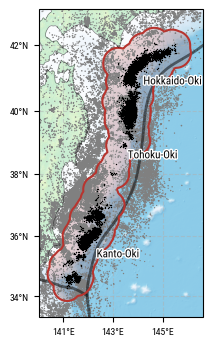

In [13]:
# Map
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': crs_jp})
    ax.set_extent([lon_min_jp, lon_max_jp, lat_min_jp, lat_max_jp])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min_jp), lon_max_jp+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min_jp), lat_max_jp, 2), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem_jp.copy()
    data_land = dem_jp.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem_jp, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min_jp, lon_max_jp, lat_min_jp, lat_max_jp], zorder=0)
    
    # Plot tremor
    ax.plot(trm_jp.lon, trm_jp.lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3)

    # Plot earthquakes
    eq_jp_in_map = (eq_jp.lon > lon_min_jp) & (eq_jp.lon < lon_max_jp) & (eq_jp.lat > lat_min_jp) & (eq_jp.lat < lat_max_jp) & (eq_jp.mag > min_mag)
    ax.scatter(eq_jp[eq_jp_in_map].lon, eq_jp[eq_jp_in_map].lat, transform=ccrs.PlateCarree(), s=eq_jp[eq_jp_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2)

    # Show 50 km distance field
    ax.contour(dist_lon_jp, dist_lat_jp, dist_field_jp, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon_jp, dist_lat_jp, dist_field_jp, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # Show trench
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    # Annotate zones
    ax.text(143.2, 35.4, 'Kanto-Oki', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(144.6, 38.6, 'Tohoku-Oki', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(145.4, 40.9, 'Hokkaido-Oki', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)

    ax.set_extent([lon_min_jp, lon_max_jp, lat_min_jp, lat_max_jp])
    plt.show()

## 2.3. <a id='toc2_3_'></a>Small map of Japan    [&#128285;](#toc0_)

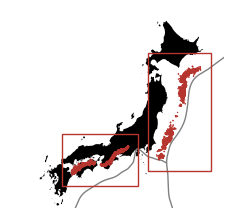

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(2.5, 2.5), subplot_kw={"projection":crs_jp})
ax.axis('off')

ax.set_extent([125.5, 148, 30, 46])
shpfilename = shpreader.natural_earth(resolution='10m',
                                    category='cultural',
                                    name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

japan = None
for country in countries:
    if country.attributes['NAME'] == 'Japan':
        japan = country.geometry
ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)
ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)

ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='k', zorder=1)
ax.add_patch(plt.Rectangle((lon_min_nk, lat_min_nk), lon_max_nk-lon_min_nk, lat_max_nk-lat_min_nk, transform=ccrs.PlateCarree(),
                                    facecolor='none', edgecolor=sci_adv_red, lw=1, zorder=3))
ax.scatter(trm_nk.lon, trm_nk.lat, s=1, c=[sci_adv_red], edgecolors='none', transform=ccrs.PlateCarree(), zorder=4)

# Japan trench tremor
ax.add_patch(plt.Rectangle((lon_min_jp, lat_min_jp), lon_max_jp-lon_min_jp, lat_max_jp-lat_min_jp, transform=ccrs.PlateCarree(),
                                    facecolor='none', edgecolor=sci_adv_red, lw=1, zorder=3))
ax.scatter(trm_jp.lon, trm_jp.lat, s=1, c=[sci_adv_red], edgecolors='none', transform=ccrs.PlateCarree(), zorder=4)



plt.tight_layout()
plt.show()

## 2.4. <a id='toc2_4_'></a>Time series of Nankai tremor   [&#128285;](#toc0_)

In [15]:
# Time series parameters
ms_trm_ts = 1.2

c_trm_ts = c_trm_map
c_eq_ts = to_rgba(sci_adv_red, 1)

figsize = np.array([10, 3])

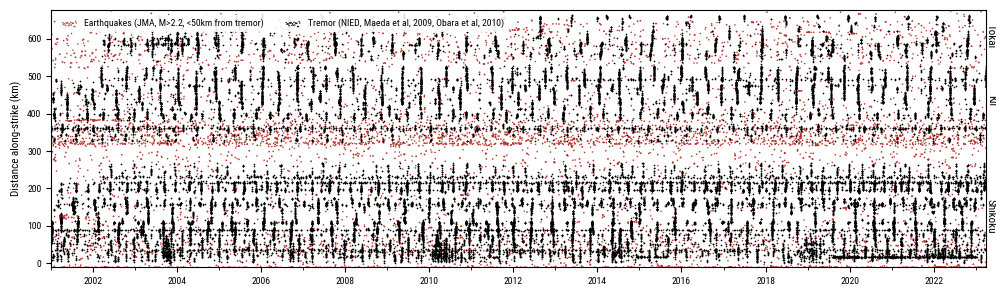

In [16]:
# Plot
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm_nk.date, trm_nk.xf, 'o', ms=1.2, mfc=c_trm_ts, mec='none', zorder=2)
    ax.scatter(eq_nk[(eq_nk.dist2trm < max_dist) & (eq_nk.mag > min_mag)].date, eq_nk[(eq_nk.dist2trm < max_dist) & (eq_nk.mag > min_mag)].xf, s=eq_nk[(eq_nk.dist2trm < max_dist) & (eq_nk.mag > min_mag)].mag/2, c=[c_eq_ts], edgecolors='none', zorder=1)
    
    ax.set_xlim([np.datetime64('2001-01-01'), trm_nk.date.max()])
    ax.set_ylim([eq_nk.xf.min(), eq_nk.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (JMA, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (NIED, Maeda et al, 2009, Obara et al, 2010)')
    ax.legend(loc='upper left', framealpha=.9, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none', ncol=2)

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))

    # Annotate zones
    txt = ax.text(1, .2, 'Shikoku', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .65, 'Kii', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .9, 'Tokai', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)

    plt.tight_layout()
    plt.show()

## 2.5. <a id='toc2_5_'></a>Japan trench time series  [&#128285;](#toc0_)

In [17]:
# Time series parameters
figsize = np.array([4, 4])

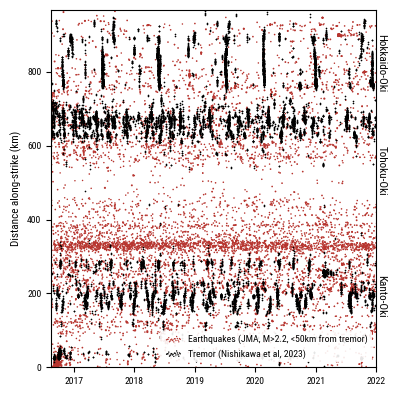

In [18]:
# Plot
with plt.style.context('grl'):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm_jp.date, trm_jp.xf, 'o', ms=1.2, mfc=c_trm_ts, mec='none', zorder=2)
    ax.scatter(eq_jp[(eq_jp.dist2trm < max_dist) & (eq_jp.mag > min_mag)].date, eq_jp[(eq_jp.dist2trm < max_dist) & (eq_jp.mag > min_mag)].xf, s=eq_jp[(eq_jp.dist2trm < max_dist) & (eq_jp.mag > min_mag)].mag/2, c=[c_eq_ts], edgecolors='none', zorder=1)
    
    ax.set_xlim([trm_jp.date.min(), np.datetime64('2022-01-01')])
    ax.set_ylim([0, trm_jp.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (JMA, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (Nishikawa et al, 2023)')
    ax.legend(loc='lower right', framealpha=.9, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none')

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(1))
    ax.xaxis.set_minor_locator(YearLocator(1))

    # Annotate zones
    txt = ax.text(1, .85, 'Hokkaido-Oki', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .55, 'Tohoku-Oki', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .2, 'Kanto-Oki', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)

    plt.tight_layout()
    plt.show()

# 3. <a id='toc3_'></a>Full figure [&#128285;](#toc0_)

In [19]:
# Parameters
# --> Maps parameters
crs_nk = ccrs.Mercator(central_longitude=trm_nk.lon.mean())

ms_trm_map = 1

c_trm_map = 'k'
c_eq_map = '.5'

crs_jp = ccrs.Mercator(central_longitude=trm_jp.lon.mean())

# --> Time series parameters
ms_trm_ts = .9

c_trm_ts = c_trm_map
c_eq_ts = to_rgba(sci_adv_red, 1)

# --> Figure layout
figsize = (7.24, 6)
adj_dict = dict(bottom=.07, top=.93, left=.07, right=.98, wspace=.2, hspace=.2)

heights = [0.45, 0.55, 660/960]
widths = [.55, .45, .5]

rasterized=False
dpi = 600

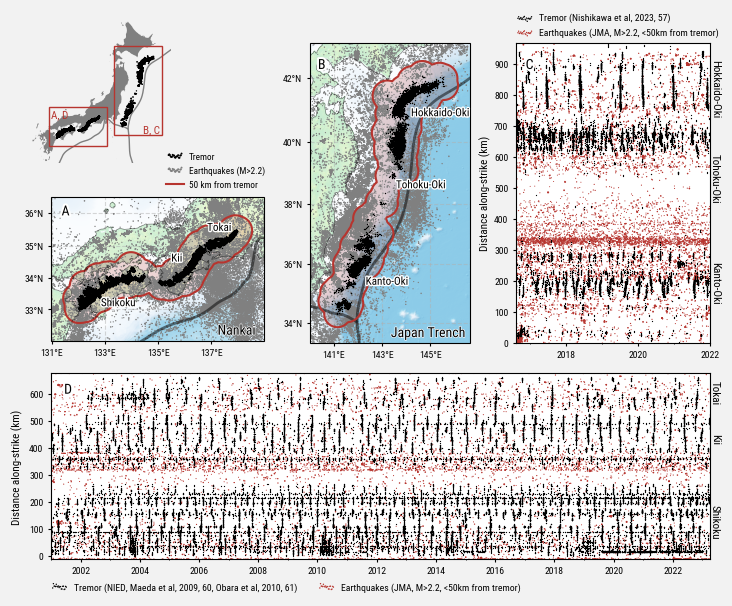

In [20]:
# Plot
with plt.style.context('grl'):
    fig = plt.figure(figsize=figsize, facecolor='.95')
    gs = fig.add_gridspec(3, 3, width_ratios=widths, height_ratios=heights)

    # Japan map  ---------------------------------------------------------------------------------------------------------
    ax = plt.axes([0, 0.73, .25, .25], projection=crs_jp)
    ax.axis('off')
    ax.set_extent([125.5, 148, 30, 46])
    shpfilename = shpreader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    japan = None
    for country in countries:
        if country.attributes['NAME'] == 'Japan':
            japan = country.geometry
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c='.5', lw=1, zorder=2)

    ax.add_geometries([japan], ccrs.PlateCarree(), facecolor='.5', zorder=1)
    ax.add_patch(plt.Rectangle((lon_min_nk, lat_min_nk), lon_max_nk-lon_min_nk, lat_max_nk-lat_min_nk, transform=ccrs.PlateCarree(),
                                        facecolor='none', edgecolor=sci_adv_red, lw=1, zorder=3))
    ax.scatter(trm_nk.lon, trm_nk.lat, s=1, c=['k'], edgecolors='none', transform=ccrs.PlateCarree(), zorder=4, rasterized=rasterized)

    ax.add_patch(plt.Rectangle((lon_min_jp, lat_min_jp), lon_max_jp-lon_min_jp, lat_max_jp-lat_min_jp, transform=ccrs.PlateCarree(),
                                        facecolor='none', edgecolor=sci_adv_red, lw=1, zorder=3))
    ax.text(lon_min_nk+.2, lat_max_nk-.2, 'A, D', c=sci_adv_red, transform=ccrs.PlateCarree(), zorder=5, va='top', ha='left')
    ax.text(lon_max_jp-.2, lat_min_jp+.1, 'B, C', c=sci_adv_red, transform=ccrs.PlateCarree(), zorder=5, va='bottom', ha='right')
    ax.scatter(trm_jp.lon, trm_jp.lat, s=1, c=['k'], edgecolors='none', transform=ccrs.PlateCarree(), zorder=4, rasterized=rasterized)

    # Nankai map  ---------------------------------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[1, 0], projection=crs_nk)
    ax.text(.05, .95, 'A', transform=ax.transAxes, va='top', ha='left', fontsize=10, path_effects=[fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal()], zorder=11)
    ax.text(.96, .02, 'Nankai', transform=ax.transAxes, va='bottom', ha='right', fontsize=10, path_effects=[fx.Stroke(linewidth=1, foreground='1.0'), fx.Normal()])
    ax.set_extent([lon_min_nk, lon_max_nk, lat_min_nk, lat_max_nk])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min_nk), lon_max_nk+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min_nk), lat_max_nk, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem_nk.copy()
    data_land = dem_nk.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem_nk, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min_nk, lon_max_nk, lat_min_nk, lat_max_nk], zorder=0)
    
    # Plot tremor
    ax.plot(trm_nk.lon, trm_nk.lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3, rasterized=rasterized)

    # Plot earthquakes
    eq_nk_in_map = (eq_nk.lon > lon_min_nk) & (eq_nk.lon < lon_max_nk) & (eq_nk.lat > lat_min_nk) & (eq_nk.lat < lat_max_nk) & (eq_nk.mag > min_mag)
    ax.scatter(eq_nk[eq_nk_in_map].lon, eq_nk[eq_nk_in_map].lat, transform=ccrs.PlateCarree(), s=eq_nk[eq_nk_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2, rasterized=rasterized)

    # Show 50 km distance field
    ax.contour(dist_lon_nk, dist_lat_nk, dist_field_nk, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon_nk, dist_lat_nk, dist_field_nk, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # Show trench
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)

    # Annotate zones
    ax.text(133.5, 33.2, 'Shikoku', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(135.7, 34.6, 'Kii', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(137.3, 35.55, 'Tokai', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)

    ax.set_extent([lon_min_nk, lon_max_nk, lat_min_nk, lat_max_nk])

    ax.scatter([], [], color=c_trm_map, edgecolors='none', s=2, label='Tremor')
    ax.scatter([], [], color=c_eq_map, edgecolors='none', s=2, label='Earthquakes (M>2.2)')
    ax.plot([], [], ls='-', c=sci_adv_red, label='50 km from tremor')
    ax.legend(loc='lower left', bbox_to_anchor=(.5, 1), fontsize='small', framealpha=0, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none')

    # Japan map  ---------------------------------------------------------------------------------------------------------
    ax = fig.add_subplot(gs[:2, 1], projection=crs_jp)
    ax.text(.05, .95, 'B', transform=ax.transAxes, va='top', ha='left', fontsize=10, path_effects=[fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal()], zorder=11)
    ax.text(.97, .01, 'Japan Trench', transform=ax.transAxes, va='bottom', ha='right', fontsize=10, path_effects=[fx.Stroke(linewidth=1, foreground='1.0'), fx.Normal()])
    ax.set_extent([lon_min_jp, lon_max_jp, lat_min_jp, lat_max_jp])
    ax.coastlines(resolution='10m', zorder=10, color=to_rgba('k', .5), lw=.5)

    # Add ticks
    ax.set_xticks(np.arange(np.ceil(lon_min_jp), lon_max_jp+1, 2), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min_jp), lat_max_jp, 2), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    # Add physical features on the map
    data_sea = dem_jp.copy()
    data_land = dem_jp.copy()
    data_sea = data_sea.astype(float)
    data_land = data_land.astype(float)
    data_sea[data_sea > -10] = np.nan
    data_land[data_land < 10] = np.nan

    ls = mcolors.LightSource(azdeg=315, altdeg=45)
    sea_colors = plt.cm.Blues_r(np.linspace(.5, 1, 128))
    land_colors = plt.cm.YlGnBu_r(np.linspace(0.7, 1., 128))
    combined_colors = np.vstack((sea_colors, land_colors))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_terrain', combined_colors)

    data_rgb = ls.shade(dem_jp, cmap=mymap, blend_mode='soft', vert_exag=1, dx=dx, dy=dy, vmin=-5000, vmax=5000)
    ax.imshow(data_rgb, transform=ccrs.PlateCarree(), extent=[lon_min_jp, lon_max_jp, lat_min_jp, lat_max_jp], zorder=0)
    
    # Plot tremor
    ax.plot(trm_jp.lon, trm_jp.lat, 'o', transform=ccrs.PlateCarree(), ms=ms_trm_map, mfc=c_trm_map, mec='none', zorder=3, rasterized=rasterized)

    # Plot earthquakes
    eq_jp_in_map = (eq_jp.lon > lon_min_jp) & (eq_jp.lon < lon_max_jp) & (eq_jp.lat > lat_min_jp) & (eq_jp.lat < lat_max_jp) & (eq_jp.mag > min_mag)
    ax.scatter(eq_jp[eq_jp_in_map].lon, eq_jp[eq_jp_in_map].lat, transform=ccrs.PlateCarree(), s=eq_jp[eq_jp_in_map].mag/3, c=c_eq_map, edgecolor='none', zorder=2, rasterized=rasterized)

    # Show 50 km distance field
    ax.contour(dist_lon_jp, dist_lat_jp, dist_field_jp, levels=[max_dist], colors=[sci_adv_red], transform=ccrs.PlateCarree(), zorder=4)
    ax.contourf(dist_lon_jp, dist_lat_jp, dist_field_jp, levels=[0, max_dist], colors=[to_rgba(sci_adv_red, .2)], transform=ccrs.PlateCarree(), zorder=0)

    # Show trench
    ax.plot(phs_trench.lon, phs_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
    ax.plot(pac_trench.lon, pac_trench.lat, transform=ccrs.PlateCarree(), c=to_rgba('k', .5), lw=2, zorder=2)
        
    # Annotate zones
    ax.text(143.2, 35.4, 'Kanto-Oki', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(144.6, 38.6, 'Tohoku-Oki', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)
    ax.text(145.4, 40.9, 'Hokkaido-Oki', transform=ccrs.PlateCarree(), fontsize=8, ha='center', va='center', path_effects=[fx.withStroke(linewidth=2, foreground='w')], zorder=5)

    ax.set_extent([lon_min_jp, lon_max_jp, lat_min_jp, lat_max_jp])

    # Time series  ---------------------------------------------------------------------------------------------------------
    # --> Japan Trench
    ax = fig.add_subplot(gs[:2, -1])
    ax.text(.05, .95, 'C', transform=ax.transAxes, va='top', ha='left', fontsize=10, path_effects=[fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal()])
    ax.set_ylabel('Distance along-strike (km)', labelpad=2)

    ax.plot(trm_jp.date, trm_jp.xf, 'o', ms=ms_trm_ts, mfc=c_trm_ts, mec='none', zorder=2, rasterized=rasterized)
    ax.scatter(eq_jp[(eq_jp.dist2trm < max_dist) & (eq_jp.mag > min_mag)].date, eq_jp[(eq_jp.dist2trm < max_dist) & (eq_jp.mag > min_mag)].xf, s=eq_jp[(eq_jp.dist2trm < max_dist) & (eq_jp.mag > min_mag)].mag**2/10, c=[c_eq_ts], edgecolors='none', zorder=1, rasterized=rasterized)
    
    ax.set_xlim([trm_jp.date.min(), np.datetime64('2022-01-01')])
    ax.set_ylim([0, trm_jp.xf.max()])

    # Legend
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (Nishikawa et al, 2023, 57)')
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (JMA, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.legend(bbox_to_anchor=(-.05, 0.99), loc='lower left', framealpha=0, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none')

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(100))

    # Annotate zones
    txt = ax.text(1, .85, 'Hokkaido-Oki', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .55, 'Tohoku-Oki', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .2, 'Kanto-Oki', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)

    # --> Nankai
    ax = fig.add_subplot(gs[-1, :])
    ax.text(.02, .95, 'D', transform=ax.transAxes, va='top', ha='left', fontsize=10, path_effects=[fx.Stroke(linewidth=3, foreground='1.0'), fx.Normal()])
    ax.set_ylabel('Distance along-strike (km)')

    ax.plot(trm_nk.date, trm_nk.xf, 'o', ms=ms_trm_ts, mfc=c_trm_ts, mec='none', zorder=2, rasterized=rasterized)
    ax.scatter(eq_nk[(eq_nk.dist2trm < max_dist) & (eq_nk.mag > min_mag)].date, eq_nk[(eq_nk.dist2trm < max_dist) & (eq_nk.mag > min_mag)].xf, s=eq_nk[(eq_nk.dist2trm < max_dist) & (eq_nk.mag > min_mag)].mag**2/10, c=[c_eq_ts], edgecolors='none', zorder=1, rasterized=rasterized)
    
    ax.set_xlim([np.datetime64('2001-01-01'), trm_nk.date.max()])
    ax.set_ylim([eq_nk.xf.min(), eq_nk.xf.max()])

    # Annotate zones
    txt = ax.text(1, .2, 'Shikoku', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .65, 'Kii', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)
    txt = ax.text(1, .9, 'Tokai', transform=ax.transAxes, fontsize=8, ha='left', va='center', rotation=270)
    txt.set_in_layout(False)

    # Legend
    ax.scatter([], [], s=1, c=[c_trm_ts], edgecolors='none', label='Tremor (NIED, Maeda et al, 2009, 60, Obara et al, 2010, 61)')
    ax.scatter([], [], s=1, c=[c_eq_ts], edgecolors='none', label=f'Earthquakes (JMA, M>{min_mag:.1f}, <{max_dist:d}km from tremor)')
    ax.legend(bbox_to_anchor=(-.015, -.08), loc='upper left', framealpha=0, scatteryoffsets=.4 + np.random.randn(20)*.2, scatterpoints=20, handletextpad=.5, edgecolor='none', ncol=2)

    # Ticks
    ax.xaxis.set_major_locator(YearLocator(2))
    ax.xaxis.set_minor_locator(YearLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(100))


    # Shorten ticks
    for ax in fig.axes:
        ax.tick_params(axis='both', which='major', length=2)
        ax.tick_params(axis='both', which='minor', length=1)

    plt.subplots_adjust(**adj_dict)
    plt.savefig('../figures/japan_main_figure.png', dpi=dpi)
    plt.savefig(f'../figures/japan_main_figure{rasterized*"_rast" + (not rasterized)*"_vect"}.pdf', dpi=dpi)
    plt.show()